# Численное решение дифференциальных уравнений


In [1]:
using DifferentialEquations, Plots

## 4. Стохастические дифференциальные уравнения

Стохастические дифференциальные уравнения - это дифференциальные уравнения с дополнительным слагаемым, представляющим собой случайный шум

$$ \frac{du}{dt}=f(u,t) + \underbrace{\sum \sigma_i(u,t)\xi_i(t)}_{\text{Шум}} $$

где $f$,$\sigma$ - заданные функции, $\xi(t)$ - случайная функция от времени. Включение стохастичности в уравнения приводит к тому, что их решением $u(t)$ так же является стохастический процесс. 

Наиболее распространенными СДУ являются СДУ с "белым шумом", описываемым при помощи [винеровского процесса](https://ru.wikipedia.org/wiki/%D0%92%D0%B8%D0%BD%D0%B5%D1%80%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81) $W(t)$. В таком случае, СДУ в дифференциальной форме имеет вид

$$du = f(u,t) dt + \sum \sigma_i(u,t) dW_i$$

К исследованию систем дифференциальных уравнений, возмущенных случайными процессами, сводится решение широкого класса задач статистической механики, электродинамики, теории управления, финансовой математики, кинетики химических реакций и др.

### 4.1 Решение скалярного стохастического дифференциального уравнения

### 4.1.1 Метод Эйлера-Маруямы

Первый явный метод Эйлера для решения СДУ был предложен Маруямой. Расчетная формула метода Эйлера-Маруямы

$$u_{k+1} = u_k + h f(t_k, u_k) + \sigma(t_k, u_k)\Delta W_k$$

где $\Delta W_k = (W_{k+1} − W_k) ∼ N(0, h)$ по определению винеровского процесса, $h$ - шаг интегрирования 

Решим уравнение с мультипликативным шумом

$$du=u(1-u) + (0.1u)dW$$ 

на интервале $t=[0, 25]$, при начальном условии $u_0=10^{-5}$

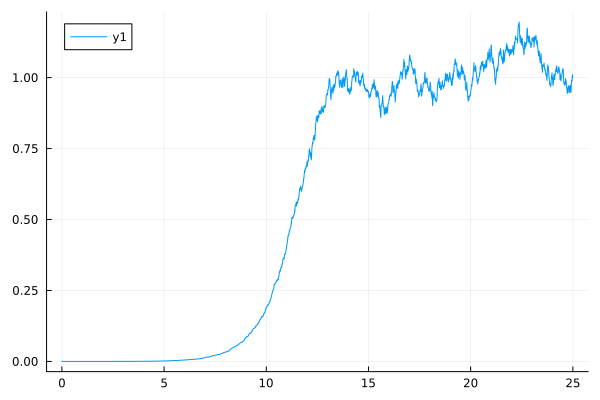

In [2]:
T  = 25              # конечное время
u₀ = 1e-5            # начальное значение
h  = 0.01            # шаг интегрирования
N  = Int64(T/h) + 1  # число точек дискретизации

f(u) = u * (1 - u)   # заданные функции
σ(u) = 0.1 * u

t = collect(0:h:T);  # вектор временных точек t = [t₀, t₁, t₂,...T]
u = zeros(N)         # вектор расчетных значений u = [u₀, u₁, u₂,..]

u[1] = u₀
for k in 1:N-1
    u[k+1] = u[k] + h * f(u[k]) + σ(u[k]) * randn() * sqrt(h)
end

plot(t, u)

### 4.1.2 Решение с использованием DifferentialEqiations.jl

Для определения задачи используется функция `SDEProblem()`, вторым аргументом которой должна быть функция $\sigma$ 

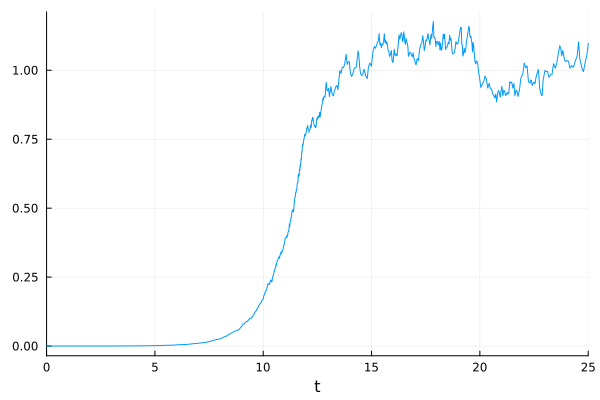

In [3]:
f(u, p, t) = u * (1 - u)                 # задание функций
σ(u, p, t) = 0.1 * u                     

prob = SDEProblem(f, σ, 1e-5, (0, 25))   # определение задачи
sol = solve(prob)                        # решение задачи
plot(sol, label="")                      # отображение решения

**Дополнительные опции функции `SDEProblem`**

`noise` - процесс шума, в DifferentialEquations имеются различные [типы процессов](https://diffeq.sciml.ai/stable/features/noise_process/#noise_process) (по умолчанию WHITE_NOISE - винеровский процесс) 

`noise_rate_prototype` - обычно матрица для задания недиагонального шума (по умолчанию nothing - диагональный шум)

**Дополнительные опции функции `solve`**

`save_noise` - сохранять в решении значения $W$ (по умолчанию true)

`seed` - инициализация генератора случайных чисел

Выбор численного [алгоритма](https://diffeq.sciml.ai/stable/solvers/sde_solve/) стохастических дифференциальных уравнений зависит от вида шумого процесса

### 4.1.3 Получение множества решений

Для вычисления нескольких траекторий методом Монте-Карло можно создать ансамблевую задачу `EnsembleProblem` и при вызове `solve` задать число вычисляемых решений с помощью `trajectories` 

In [4]:
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, trajectories=10);

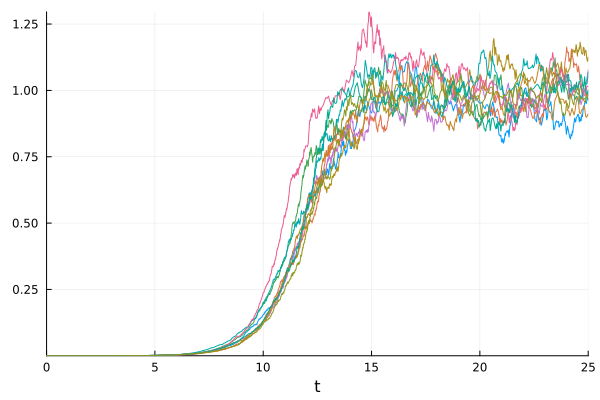

In [5]:
plot(sol)

По умолчанию расчет распаралливается на нескольких потоках. О распараллеливании на GPU и других возможностях, предоставляемых ансамблевой симуляцией, см. [здесь](https://diffeq.sciml.ai/stable/features/ensemble/#ensemble) 

Средства [анализа](https://diffeq.sciml.ai/stable/features/ensemble/#Analyzing-an-Ensemble-Experiment) множественных решений позволяют вычислять различные статистики (среднее, медиану, дисперсию, квантили и др) для стохастических решений, а так же делать обобщенную визуализацию:

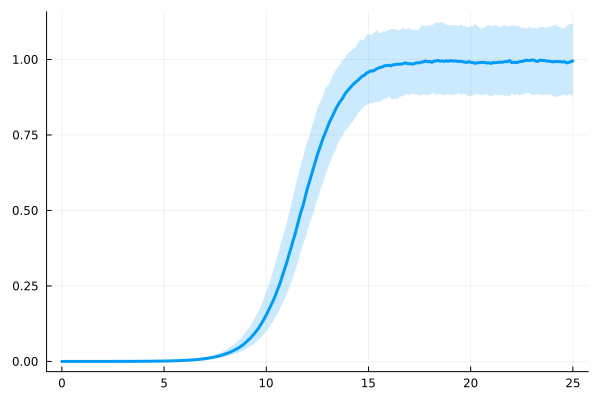

In [6]:
sol = solve(ensembleprob, trajectories=1000);  # Вычисляем 1000 траекторий

summ = EnsembleSummary(sol, 0:0.1:25)          # Вычисление среднего и дисперсии для t=0:0.1:25
plot(summ)                                     # по умолчанию границы задаются квантилями 5 и 95% 

### 4.2 Решение системы стохастических дифференциальных уравнений

Рассмотрим [модель Лотки-Вольтерры](https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%9B%D0%BE%D1%82%D0%BA%D0%B8_%E2%80%94_%D0%92%D0%BE%D0%BB%D1%8C%D1%82%D0%B5%D1%80%D1%80%D1%8B), описывающую изменение численности конкурирующих видов животных

$$\frac{dx}{dt}=\alpha x -\beta yx$$
$$\frac{dy}{dt}=-\gamma y +\delta xy $$

где $x$, $y$ - численность популяции жертв и хищников, $\alpha$, $\delta$ - их постоянные коэффициенты рождаемости, $\beta$, $\gamma$ - их постоянные коэффициенты смертности 

Предположим, что параметры $\alpha$ и $\gamma$ имеют случайную составляющую
$$\alpha(t) = \alpha_o + \sigma_1 \xi_1(t)$$
$$\gamma(t) = \gamma_o + \sigma_2 \xi_2(t)$$

где $\alpha_o$, $\gamma_o$, $\sigma_1$, $\sigma_2$ - постоянные, а $\xi_1(t)$ и $\xi_2(t)$ - случайные процессы, которые при определенных условиях существования конкурирующих видов животных могут считаться независимыми белыми шумами. Тогда стохастический вариант модели Лотки-Вольтерры имеет вид

$$\frac{dx}{dt}=(\alpha_o  -\beta y)x + \sigma_1 x \xi_1$$
$$\frac{dy}{dt}=(-\gamma_o  +\delta x)y - \sigma_2 y \xi_2$$


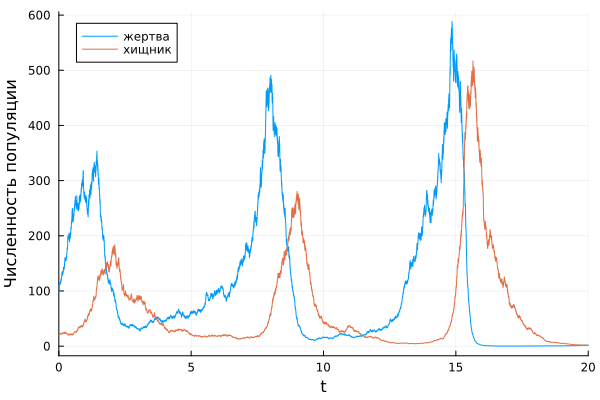

In [7]:
function lottka!(du, u, p, t)  
    αₒ, γₒ, β, δ, ~, ~ = p
    x, y  = u
    du[1] = ( αₒ - β*y) * x
    du[2] = (-γₒ + δ*x) * y
    nothing
end    

function lottka_noise!(du, u, p, t)
    ~, ~, ~, ~, σ₁, σ₂ = p
    x, y  = u
    du[1] = σ₁ * x
    du[2] = - σ₂ * y
end

u₀ = [100,20]                         # начальная популяция
p  = [1.2, 1.1, 0.02, 0.01, 0.3, 0.3] #  αₒ, γₒ, β, δ, σ₁, σ₂
tspan = (0, 20)

prob  = SDEProblem(lottka!, lottka_noise!, u₀, tspan, p)   # определение задачи
sol   = solve(prob)                                         # решение задачи
plot(sol, label = ["жертва" "хищник"], ylabel = "Численность популяции") 
    

Фазовый портрет для системы Лотки-Вольтерры

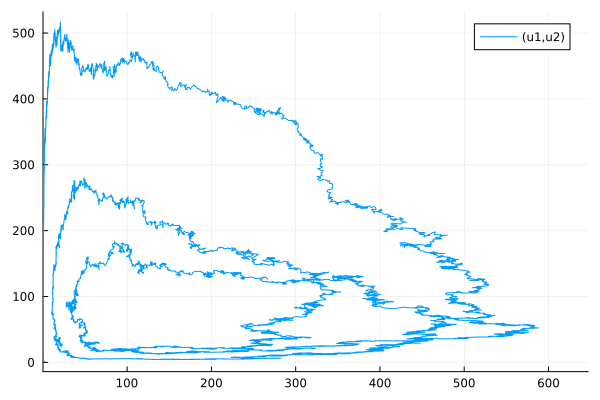

In [8]:
plot(sol, idxs=(1,2))

### 4.3 Решение системы стохастических дифференциально-алгебраических уравнений

![Image](http://ets.ifmo.ru/osipov/os1/3_2.files/image031.jpg)

Cистема уравнений цепи при наличии аддитивного шума в ветви с индуктивностью:

\begin{equation*}
 \begin{cases}
   0 = i_i - i_2 - i_L
   \\
   0 = E -r_1 i_1 - r_2 i_2
   \\
   L\frac{di_L}{dt}=r_2 i_2 + k \xi
 \end{cases}
\end{equation*}

Замечания
* Решение СДАУ возможно только в форме с матрицей масс ([список решателей](https://diffeq.sciml.ai/stable/solvers/sdae_solve/))
* Добавление шума возможно только для дифференциальных уравнений

Для моделирования шума в алгебраических уравнениях 
* задать соответствующему диагональному элементу матрицы масс ненулевое малое значение
* либо использовать фиктивные переменные

In [9]:
using LinearAlgebra

function circuit!(du, u, p, t)
    E,  r1, r2 = p
    i1, i2, iL = u
    du[1] = i1 - i2 - iL
    du[2] = E - r1 * i1 - r2 * i2
    du[3] = r2 * i2
    nothing
end

function L_noise!(du, u, p, t)
    i1, i2, iL = u
    du[1] = 0
    du[2] = 0
    du[3] = 1.2
end

u0    = [25.0, 25, 0]
tspan = (0, 10)
p     = (10, 0.2, 0.2) # E, r1, r2
L     = 0.1

M        = diagm(0 => [0, 0, L])
circuit  = SDEFunction(circuit!, L_noise!, mass_matrix = M)
prob     = SDEProblem( circuit,  L_noise!, u0, tspan, p);

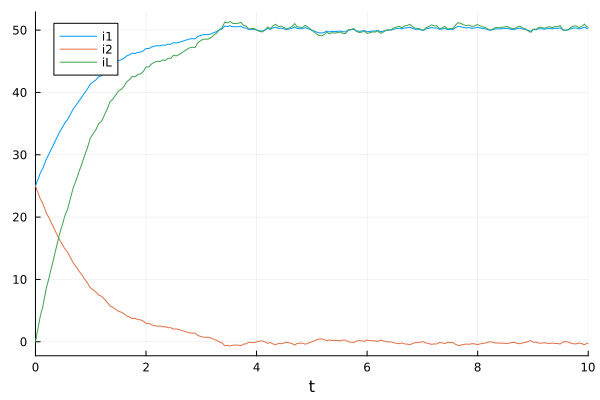

In [10]:
sol = solve(prob, reltol = 1e-4)
plot(sol, label = ["i1" "i2" "iL"])

In [11]:
# Проверка соблюдения первого закона Кирхгофа для первых 30 точек
for i=1:30
    println(sol.u[i][1] - sol.u[i][2] - sol.u[i][3])
end

0.0
3.301178774783864e-15
4.461079899853882e-5
5.238864897449957e-16
5.311227424673742e-5
1.1518563880486e-15
-6.970876485225264e-5
-1.3322676295501878e-15
7.1445391119071e-5
4.274358644806853e-15
-2.5124848163637914e-6
7.494005416219807e-16
-2.6567067628879837e-6
-2.7755575615628914e-16
7.534625334856826e-6
-2.7478019859472624e-15
-3.986852885939918e-6
-2.220446049250313e-16
6.76940431598716e-7
-3.3306690738754696e-15
5.835174127222231e-8
-2.4980018054066022e-15
-2.480946974525722e-7
-1.2212453270876722e-15
2.975640301383642e-7
-1.1102230246251565e-15
3.003844362137187e-7
4.440892098500626e-16
-9.900075710334022e-7
-1.2212453270876722e-15


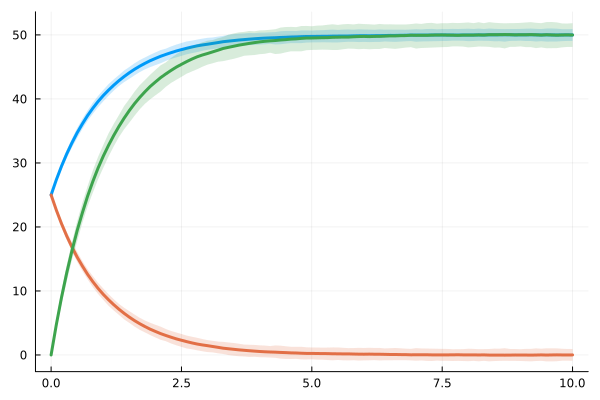

In [12]:
ensembleprob = EnsembleProblem(prob)
sol  = solve(ensembleprob, ImplicitRKMil(), trajectories = 1000);  
summ = EnsembleSummary(sol, 0:0.1:10, quantiles = [0.01,0.99])
plot(summ)